Our first neural network 
==================================

In [25]:
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

torch.set_printoptions(edgeitems=2, linewidth=75)

## Data

In [ ]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]

Reshape the inputs as a $B \times N$ matrix where $B$ is the batch size and $N$ is the number of features

In [ ]:
t_c = torch.tensor(t_c).unsqueeze(1) # <1>
t_u = torch.tensor(t_u).unsqueeze(1) # <1>

t_u.shape

torch.Size([11, 1])

Split into training and validation

In [3]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 9,  3, 10,  0,  7,  4,  2,  1,  8]), tensor([5, 6]))

In [4]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

## Linear model with `nn`

### Playing around, inspecting the model

In [5]:
import torch.nn as nn

linear_model = nn.Linear(1, 1) # <1>
linear_model(t_un_val)

tensor([[-3.9140],
        [-2.7404]], grad_fn=<AddmmBackward0>)

Parameters

In [6]:
linear_model.weight

Parameter containing:
tensor([[-0.7824]], requires_grad=True)

In [7]:
linear_model.bias

Parameter containing:
tensor([-0.0879], requires_grad=True)

This performs the operation `weight * x + bias`

In [10]:
x = torch.ones(1)
linear_model(x)

tensor([-0.8704], grad_fn=<ViewBackward0>)

Applies the untrained model to a batch: size 10, 1 feature

In [11]:
x = torch.ones(10, 1)
linear_model(x)

tensor([[-0.8704],
        [-0.8704],
        [-0.8704],
        [-0.8704],
        [-0.8704],
        [-0.8704],
        [-0.8704],
        [-0.8704],
        [-0.8704],
        [-0.8704]], grad_fn=<AddmmBackward0>)

### The training loop

In [16]:
linear_model = nn.Linear(1, 1) # <1>
optimizer = optim.SGD(
    linear_model.parameters(), # <2>
    lr=1e-2)

In [17]:
linear_model.parameters()

<generator object Module.parameters at 0x11892aea0>

In [18]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[-0.1943]], requires_grad=True),
 Parameter containing:
 tensor([0.4046], requires_grad=True)]

In [19]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        # training
        t_p_train = model(t_u_train) # <1> model is passed in
        loss_train = loss_fn(t_p_train, t_c_train)

        # validation
        t_p_val = model(t_u_val) # <1>
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward() # <2> loss is passed in
        optimizer.step() # updates parameters

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")


#### With a manually defined loss

In [20]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

linear_model = nn.Linear(1, 1) # <1>
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = loss_fn,
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 126.6296, Validation loss 10.2071
Epoch 1000, Training loss 3.9881, Validation loss 1.4352
Epoch 2000, Training loss 2.9437, Validation loss 2.9133
Epoch 3000, Training loss 2.9059, Validation loss 3.3930

Parameter containing:
tensor([[5.4993]], requires_grad=True)
Parameter containing:
tensor([-18.1357], requires_grad=True)


#### Built-in loss function

In [21]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(), # <1>
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 117.0198, Validation loss 7.1940
Epoch 1000, Training loss 4.0819, Validation loss 1.4061
Epoch 2000, Training loss 2.9471, Validation loss 2.8899
Epoch 3000, Training loss 2.9060, Validation loss 3.3880

Parameter containing:
tensor([[5.4984]], requires_grad=True)
Parameter containing:
tensor([-18.1303], requires_grad=True)


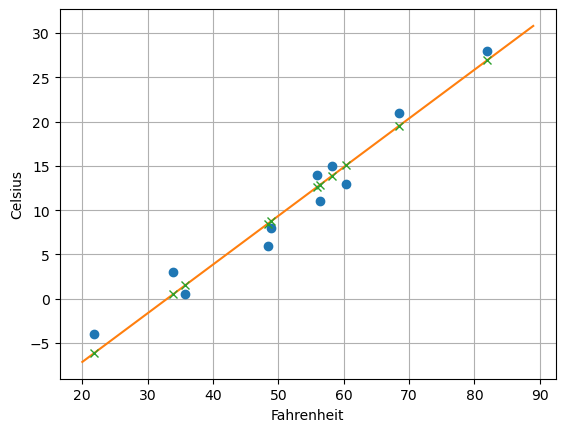

In [28]:
t_range = torch.arange(20., 90.).unsqueeze(1)

plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
#plt.grid(True)
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), linear_model(0.1 * t_range).detach().numpy())
plt.plot(t_u.numpy(), linear_model(0.1 * t_u).detach().numpy(), 'x')

## Neural network

Keep everything fixed from above, except the model.

The NN architecture is displayed below.

![Alt text](arch.png)

### Define the architecture

The model fans out from 1 input feature to 13 hidden features, passes them through a tanh activation, and lin- early combines the resulting 13 numbers into 1 output feature.

In [44]:
seq_model = nn.Sequential(
            nn.Linear(1, 13), # <1>
            nn.Tanh(),
            nn.Linear(13, 1)) # <2>
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

### Inspect the parameters

In [45]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

Identify parameters by name

In [32]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


One can be more descriptive when defining an architecture. This is the actual architecture to be used

In [42]:
from collections import OrderedDict

seq_model2 = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8, 1))
]))

seq_model2

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [43]:
for name, param in seq_model2.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


Access parameters by using submodules as attributes

In [37]:
seq_model.output_linear.bias

Parameter containing:
tensor([0.1615], requires_grad=True)

### Training

In [47]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3) # <1> learning rate decreased

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)
    
print('output', seq_model(t_un_val))
print('answer', t_c_val)
#print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 1.4821, Validation loss 5.9048
Epoch 1000, Training loss 1.4772, Validation loss 5.9120
Epoch 2000, Training loss 1.4745, Validation loss 5.9327
Epoch 3000, Training loss 1.4726, Validation loss 5.9595
Epoch 4000, Training loss 1.4713, Validation loss 5.9878
Epoch 5000, Training loss 1.4702, Validation loss 6.0153
output tensor([[ 7.1480],
        [-0.3623]], grad_fn=<AddmmBackward0>)
answer tensor([[8.],
        [3.]])


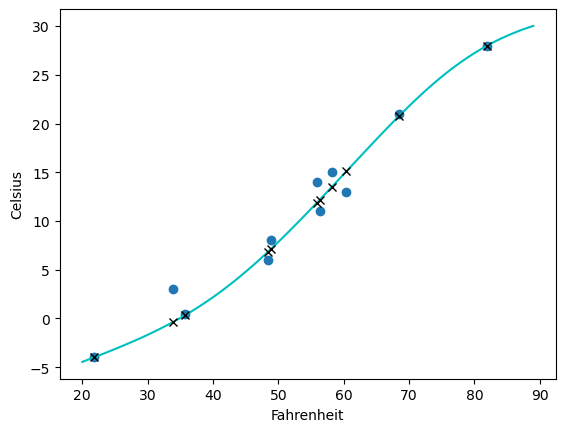

In [48]:
t_range = torch.arange(20., 90.).unsqueeze(1)

plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')

Isn't it just remarkable that the NN invents a function that reproduces the data?

## Exercises

### 1. Varying complexity of hidden layer

Experiment with the number of hidden neurons in our simple neural network model, as well as the learning rate.

#### Number of neurons

Returns a NN with the specified number of neurons in the hidden layer

In [88]:
def nn_model(n):
    return nn.Sequential(
            nn.Linear(1, n),
            nn.Tanh(),
            nn.Linear(n, 1))

Creates a sequence of integers ranging from 1 to some specified value `imax`, in steps of `istep` (clippy-generated)

In [69]:
def create_sequence(imax, istep=1):
    return list(range(1, imax + 1, istep))

# generates a list of number of neurons, to be investigated
neurons=create_sequence(30,4)

Loop that trains on the data, varying the number of neurons

In [60]:
from tqdm import tqdm

In [70]:
# list w/ number of neurons
nList=[]
# list w/ corresponding trained NN model
modelList=[]

In [71]:
for i in tqdm(neurons):
    model = nn_model(i)
    optimizer = optim.SGD(model.parameters(), lr=1e-3) 
    training_loop(n_epochs = 5000, optimizer = optimizer, model = model, loss_fn = nn.MSELoss(), t_u_train = t_un_train, t_u_val = t_un_val, t_c_train = t_c_train, t_c_val = t_c_val)

    nList.append(i)
    modelList.append(model)

  0%|                                                     | 0/8 [00:00<?, ?it/s]

Epoch 1, Training loss 252.9204, Validation loss 52.0176
Epoch 1000, Training loss 18.7870, Validation loss 6.1411
Epoch 2000, Training loss 25.1018, Validation loss 19.2613
Epoch 3000, Training loss 11.9253, Validation loss 23.6261


 12%|█████▋                                       | 1/8 [00:00<00:05,  1.35it/s]

Epoch 4000, Training loss 9.0287, Validation loss 17.1311
Epoch 5000, Training loss 9.0481, Validation loss 13.3232
Epoch 1, Training loss 248.5604, Validation loss 49.5712
Epoch 1000, Training loss 12.1576, Validation loss 6.2660
Epoch 2000, Training loss 5.1862, Validation loss 3.3926
Epoch 3000, Training loss 2.5448, Validation loss 3.5231
Epoch 4000, Training loss 1.7062, Validation loss 4.3467


 25%|███████████▎                                 | 2/8 [00:01<00:04,  1.39it/s]

Epoch 5000, Training loss 1.5294, Validation loss 5.0889
Epoch 1, Training loss 236.7276, Validation loss 44.4182
Epoch 1000, Training loss 10.2784, Validation loss 6.2615
Epoch 2000, Training loss 4.2064, Validation loss 4.2375
Epoch 3000, Training loss 2.3297, Validation loss 4.4705


 38%|████████████████▉                            | 3/8 [00:02<00:03,  1.40it/s]

Epoch 4000, Training loss 1.7130, Validation loss 4.9901
Epoch 5000, Training loss 1.5412, Validation loss 5.3993
Epoch 1, Training loss 220.7583, Validation loss 37.1377
Epoch 1000, Training loss 3.5099, Validation loss 5.5285
Epoch 2000, Training loss 4.2265, Validation loss 4.2443
Epoch 3000, Training loss 2.4957, Validation loss 4.4052
Epoch 4000, Training loss 1.8365, Validation loss 4.8547


 50%|██████████████████████▌                      | 4/8 [00:02<00:02,  1.40it/s]

Epoch 5000, Training loss 1.6006, Validation loss 5.2381
Epoch 1, Training loss 230.7849, Validation loss 41.6300
Epoch 1000, Training loss 3.6218, Validation loss 5.7127
Epoch 2000, Training loss 3.9109, Validation loss 4.1399
Epoch 3000, Training loss 2.5022, Validation loss 4.1157


 62%|████████████████████████████▏                | 5/8 [00:03<00:02,  1.40it/s]

Epoch 4000, Training loss 1.9339, Validation loss 4.3879
Epoch 5000, Training loss 1.7132, Validation loss 4.6717
Epoch 1, Training loss 222.4960, Validation loss 37.7061
Epoch 1000, Training loss 2.8966, Validation loss 5.2298
Epoch 2000, Training loss 3.1535, Validation loss 3.9575
Epoch 3000, Training loss 2.1857, Validation loss 4.0954
Epoch 4000, Training loss 1.8326, Validation loss 4.3764


 75%|█████████████████████████████████▊           | 6/8 [00:04<00:01,  1.40it/s]

Epoch 5000, Training loss 1.6867, Validation loss 4.6381
Epoch 1, Training loss 220.0741, Validation loss 36.1391
Epoch 1000, Training loss 3.0665, Validation loss 5.0305
Epoch 2000, Training loss 3.3448, Validation loss 7.4115
Epoch 3000, Training loss 2.3312, Validation loss 6.7345


 88%|███████████████████████████████████████▍     | 7/8 [00:05<00:00,  1.38it/s]

Epoch 4000, Training loss 1.9115, Validation loss 6.3969
Epoch 5000, Training loss 1.7285, Validation loss 6.2604
Epoch 1, Training loss 218.1028, Validation loss 35.0890
Epoch 1000, Training loss 2.6922, Validation loss 5.0189
Epoch 2000, Training loss 3.1873, Validation loss 3.8531
Epoch 3000, Training loss 2.2013, Validation loss 4.0990
Epoch 4000, Training loss 1.8195, Validation loss 4.4604


100%|█████████████████████████████████████████████| 8/8 [00:05<00:00,  1.38it/s]

Epoch 5000, Training loss 1.6590, Validation loss 4.7817


Text(0.5, 1.0, 'Varying neurons')

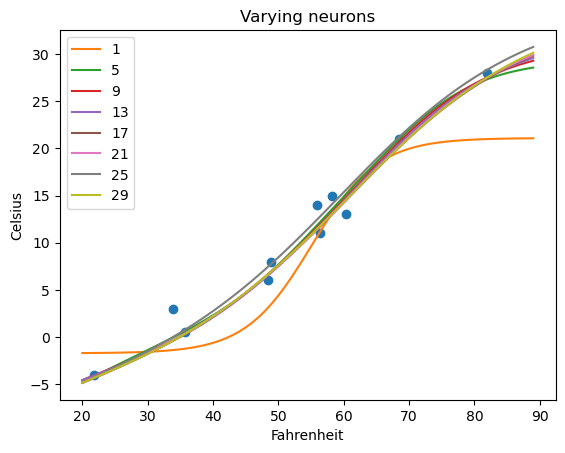

In [72]:
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

for i in range(len(nList)):
    plt.plot(t_range.numpy(), modelList[i](0.1 * t_range).detach().numpy(),label=str(nList[i]))

plt.legend()
plt.title("Varying neurons")

#### Learning rate

Learning rates to be explored

In [82]:
lr=[1e-4,1e-3,0.01,0.1]

In [83]:
# list w/ corresponding trained NN model
lrList=[]

In [89]:
for i in tqdm(lr):
    model = nn_model(8)
    optimizer = optim.SGD(model.parameters(), lr=i) 
    training_loop(n_epochs = 5000, optimizer = optimizer, model = model, loss_fn = nn.MSELoss(), t_u_train = t_un_train, t_u_val = t_un_val, t_c_train = t_c_train, t_c_val = t_c_val)

    lrList.append(model)

  0%|                                                     | 0/4 [00:00<?, ?it/s]

Epoch 1, Training loss 235.4431, Validation loss 43.8176
Epoch 1000, Training loss 70.2321, Validation loss 10.8049
Epoch 2000, Training loss 40.8690, Validation loss 7.1942
Epoch 3000, Training loss 25.1127, Validation loss 3.1165


 25%|███████████▎                                 | 1/4 [00:00<00:02,  1.32it/s]

Epoch 4000, Training loss 16.0754, Validation loss 1.7063
Epoch 5000, Training loss 11.2839, Validation loss 2.4423
Epoch 1, Training loss 227.5485, Validation loss 39.6704
Epoch 1000, Training loss 9.8507, Validation loss 14.2120
Epoch 2000, Training loss 5.7426, Validation loss 11.6355
Epoch 3000, Training loss 3.0271, Validation loss 9.8173
Epoch 4000, Training loss 1.9790, Validation loss 8.2459


 50%|██████████████████████▌                      | 2/4 [00:01<00:01,  1.35it/s]

Epoch 5000, Training loss 1.6516, Validation loss 7.2872
Epoch 1, Training loss 227.1906, Validation loss 39.4308
Epoch 1000, Training loss 78.5581, Validation loss 21.2726
Epoch 2000, Training loss 60.9139, Validation loss 105.1883
Epoch 3000, Training loss 21.3950, Validation loss 1.2476


 75%|█████████████████████████████████▊           | 3/4 [00:02<00:00,  1.37it/s]

Epoch 4000, Training loss 22.4711, Validation loss 3.2915
Epoch 5000, Training loss 33.0493, Validation loss 28.8113
Epoch 1, Training loss 228.3634, Validation loss 39.7393
Epoch 1000, Training loss 86.1004, Validation loss 43.5971
Epoch 2000, Training loss 86.0993, Validation loss 43.5967
Epoch 3000, Training loss 86.0988, Validation loss 43.5971
Epoch 4000, Training loss 86.1540, Validation loss 40.7845


100%|█████████████████████████████████████████████| 4/4 [00:02<00:00,  1.37it/s]

Epoch 5000, Training loss 86.0989, Validation loss 43.5957


Text(0.5, 1.0, 'Varying learning rate')

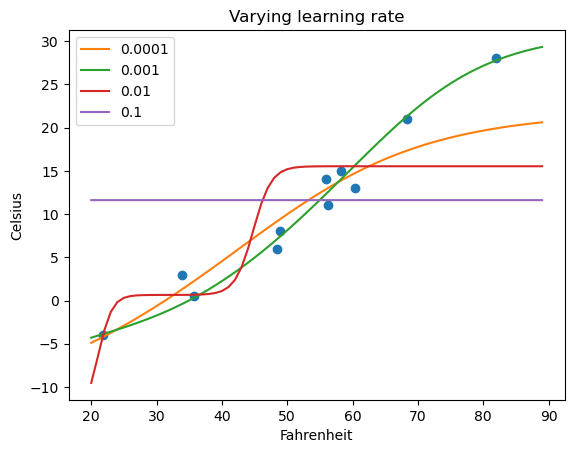

In [90]:
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

for i in range(len(lrList)):
    plt.plot(t_range.numpy(), lrList[i](0.1 * t_range).detach().numpy(),label=str(lr[i]))

plt.legend()
plt.title("Varying learning rate")

#### What changes result in more linear output from the model?

Increasing number of neurons and decreasing learning rate (up to a threshold).

#### Can you get the model to obviously overfit the data?

No. At least not within the range of neurons explored.

## Sandbox

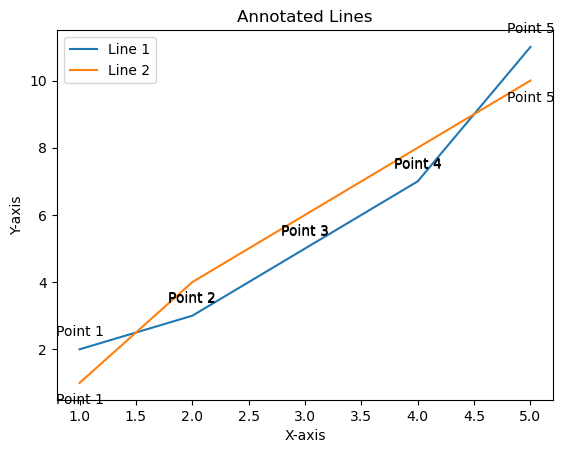

In [67]:
import matplotlib.pyplot as plt

# Sample data
x = [1, 2, 3, 4, 5]
y1 = [2, 3, 5, 7, 11]
y2 = [1, 4, 6, 8, 10]

# Create the plot
plt.plot(x, y1, label='Line 1')
plt.plot(x, y2, label='Line 2')

# Annotate points on the first line
for i, txt in enumerate(y1):
    plt.annotate(f'Point {i+1}', (x[i], y1[i]), textcoords="offset points", xytext=(0,10), ha='center')

# Annotate points on the second line
for i, txt in enumerate(y2):
    plt.annotate(f'Point {i+1}', (x[i], y2[i]), textcoords="offset points", xytext=(0,-15), ha='center')

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Annotated Lines')
plt.legend()

# Show plot
plt.show()

In [87]:
nn_model(9)

TypeError: linear(): argument 'input' (position 1) must be Tensor, not int